# PyTorch 2.0 (abbreviated as PT2) a primer

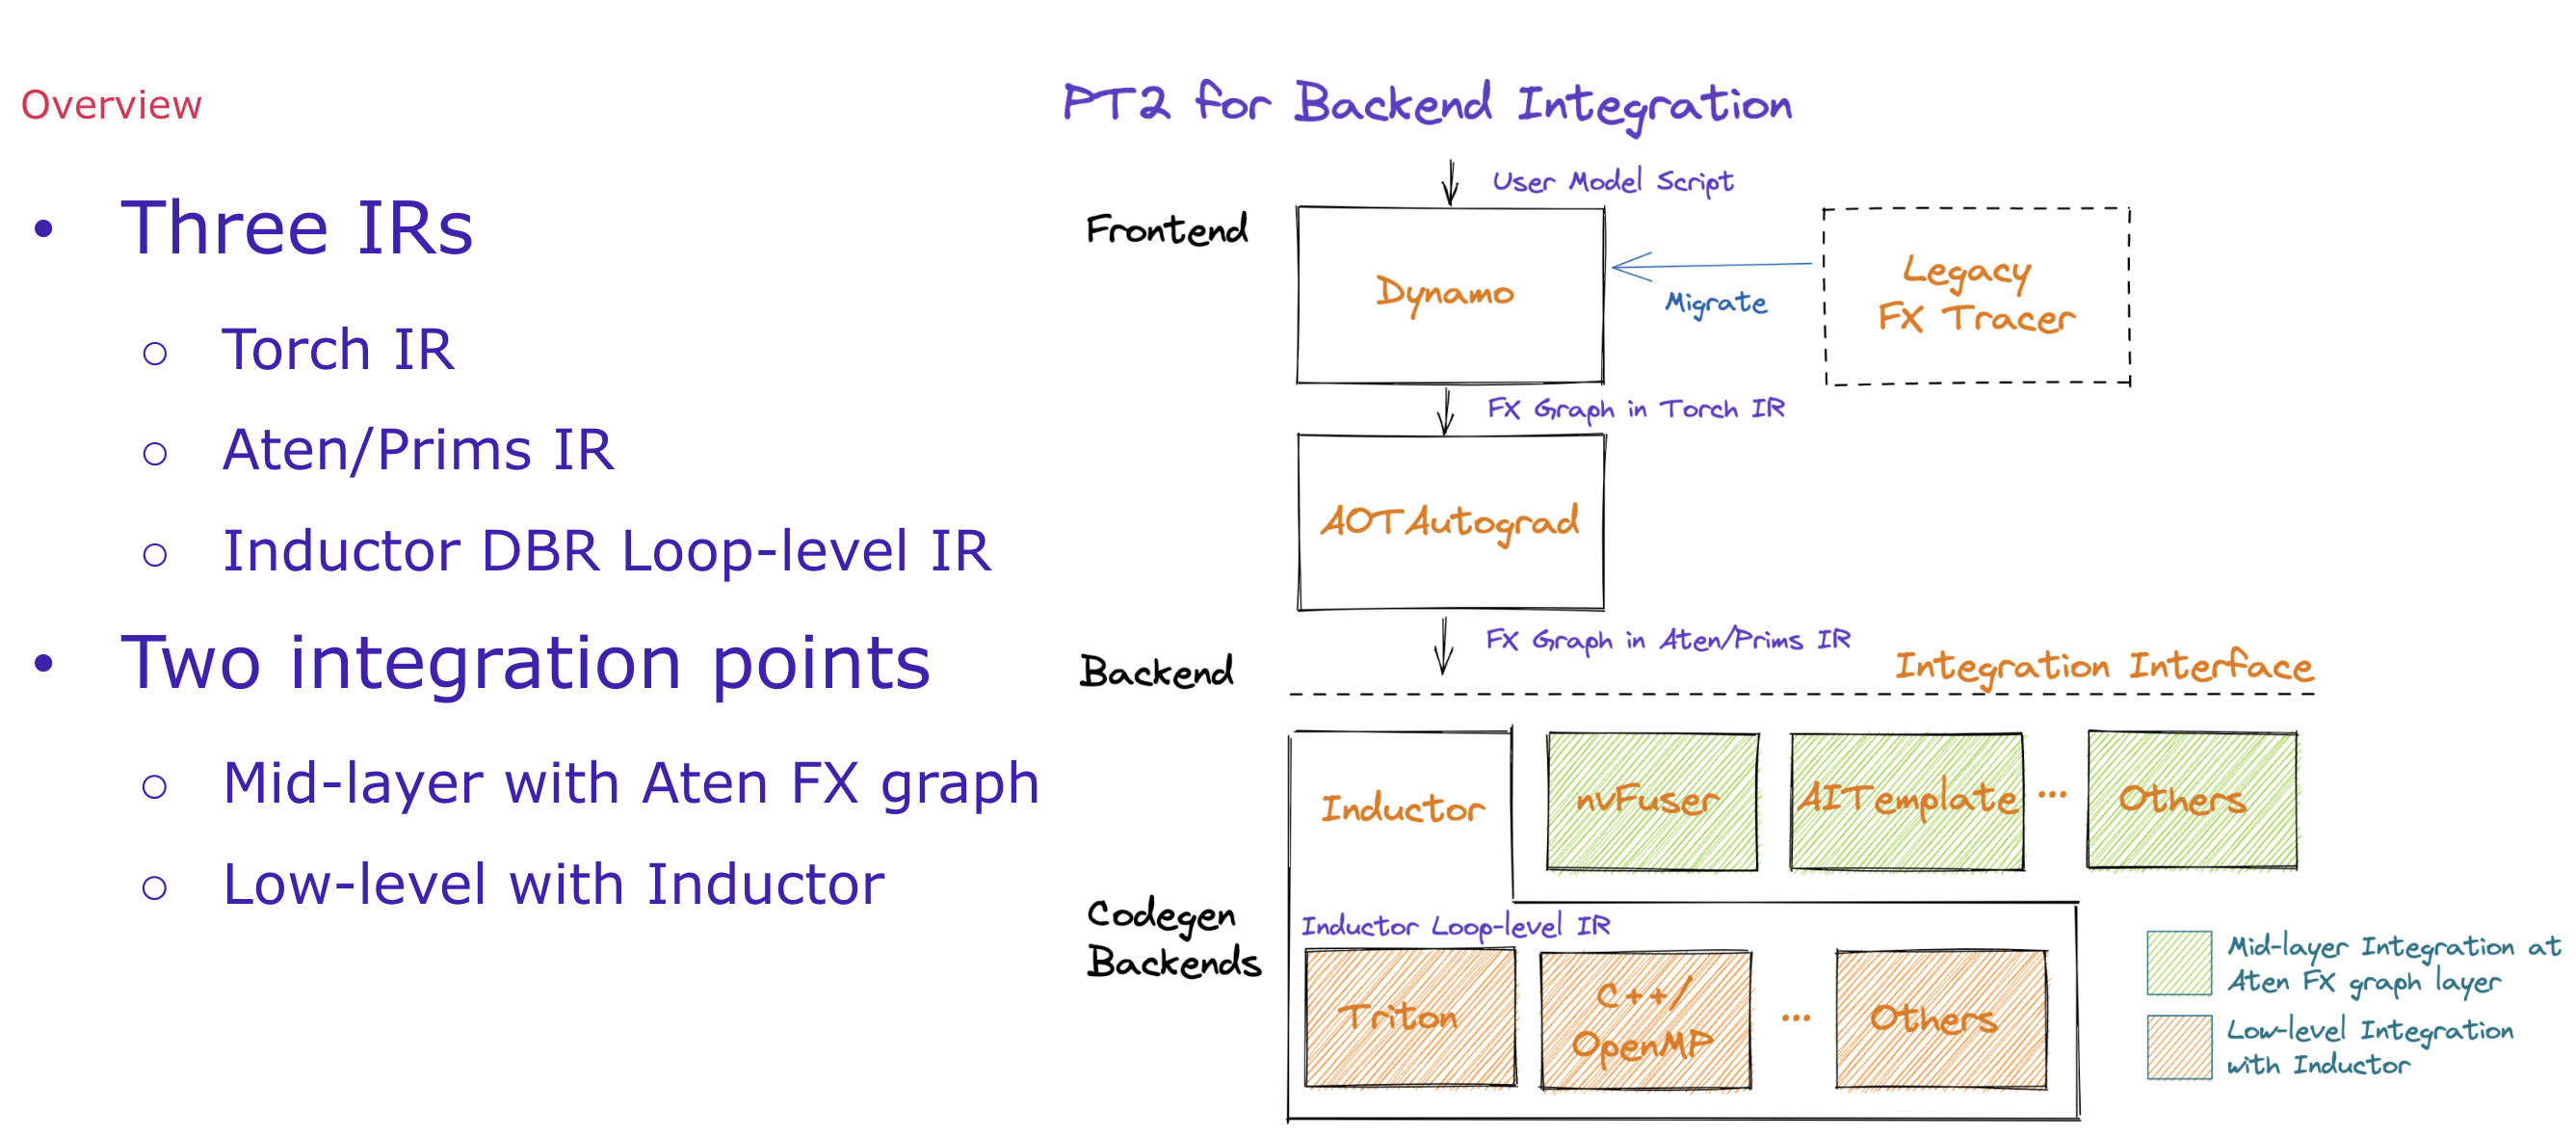

The entire PT2 stack is build on an IR called FX Graphs. So let us have a look into FXGraphs, and then we shall continue from there.

# Torch FX

The FX Graph and its related source codes are available at `torch/fx` directory.

FX is a toolkit for developers to use to transform nn.Module instances. FX consists of three main components: a `symbolic tracer`, an `intermediate representation`, and `Python code generation`. A demonstration of these components in action:

In [1]:
import torch
import torch.fx

class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.param = torch.nn.Parameter(torch.rand(3, 4))
        self.linear = torch.nn.Linear(4, 5)

    def forward(self, x):
        return torch.topk(torch.sum(self.linear(x + self.linear.weight).relu(), dim=-1), 3)

module = MyModule()

Symbolic tracing frontend - captures the semantics of the module


In [2]:
from torch.fx import symbolic_trace
symbolic_traced : torch.fx.GraphModule = symbolic_trace(module)

print(f"{type(symbolic_traced)=}")

print(f"{symbolic_traced = }")

type(symbolic_traced)=<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>
symbolic_traced = MyModule(
  (linear): Linear(in_features=4, out_features=5, bias=True)
)


High-level intermediate representation (IR) - Graph representation


In [3]:
print(symbolic_traced.graph) # this graph is the FX Graph

graph():
    %x : [num_users=1] = placeholder[target=x]
    %linear_weight : [num_users=1] = get_attr[target=linear.weight]
    %add : [num_users=1] = call_function[target=operator.add](args = (%x, %linear_weight), kwargs = {})
    %linear : [num_users=1] = call_module[target=linear](args = (%add,), kwargs = {})
    %relu : [num_users=1] = call_method[target=relu](args = (%linear,), kwargs = {})
    %sum_1 : [num_users=1] = call_function[target=torch.sum](args = (%relu,), kwargs = {dim: -1})
    %topk : [num_users=1] = call_function[target=torch.topk](args = (%sum_1, 3), kwargs = {})
    return topk


Code generation - valid Python code

In [4]:
print(symbolic_traced.code)




def forward(self, x):
    linear_weight = self.linear.weight
    add = x + linear_weight;  x = linear_weight = None
    linear = self.linear(add);  add = None
    relu = linear.relu();  linear = None
    sum_1 = torch.sum(relu, dim = -1);  relu = None
    topk = torch.topk(sum_1, 3);  sum_1 = None
    return topk
    


The **symbolic tracer** performs “symbolic execution” of the Python code. It feeds fake values, called Proxies, through the code. Operations on theses Proxies are recorded. More information about symbolic tracing can be found in the `symbolic_trace()` and `Tracer` documentation.

The **intermediate representation** is the container for the operations that were recorded during symbolic tracing. It consists of a list of **Nodes** that represent function inputs, callsites (to functions, methods, or torch.nn.Module instances), and return values. More information about the IR can be found in the documentation for `Graph`. The IR is the format on which transformations are applied.

**Python code generation** is what makes FX a Python-to-Python (or Module-to-Module) transformation toolkit. For each Graph IR, we can create valid Python code matching the Graph’s semantics. This functionality is wrapped up in GraphModule, which is a torch.nn.Module instance that holds a Graph as well as a forward method generated from the Graph.

#### A Quick Primer on Graphs

Full treatment of the semantics of graphs can be found in the **Graph** documentation, but we are going to cover the basics here. A Graph is a data structure that represents a method on a GraphModule. The information that this requires is:

- What are the inputs to the method?

- What are the operations that run inside the method?

- What is the output (i.e. return) value from the method?

All three of these concepts are represented with `Node` instances. Let’s see what we mean by that with a short example:

In [5]:

class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.param = torch.nn.Parameter(torch.rand(3, 4))
        self.linear = torch.nn.Linear(4, 5)

    def forward(self, x):
        return torch.topk(torch.sum(
            self.linear(x + self.linear.weight).relu(), dim=-1), 3)

m = MyModule()
gm = torch.fx.symbolic_trace(m)

graph = gm.graph

In [6]:
graph.print_tabular()

opcode         name           target                                                   args                kwargs       meta
-------------  -------------  -------------------------------------------------------  ------------------  -----------  ----------------------------------------------------------------------------------------------------
placeholder    x              x                                                        ()                  {}           {}
get_attr       linear_weight  linear.weight                                            ()                  {}           {}
call_function  add            <built-in function add>                                  (x, linear_weight)  {}           {}
call_module    linear         linear                                                   (add,)              {}           {'nn_module_stack': OrderedDict([('linear', ('linear', <class 'torch.nn.modules.linear.Linear'>))])}
call_method    relu           relu                              

In [7]:
x = gm.print_readable()

class MyModule(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        linear_weight = self.linear.weight
        add = x + linear_weight;  x = linear_weight = None
        linear = self.linear(add);  add = None
        relu = linear.relu();  linear = None
        sum_1 = torch.sum(relu, dim = -1);  relu = None
        topk = torch.topk(sum_1, 3);  sum_1 = None
        return topk
        


We can use this information to answer the questions we posed above.

- What are the inputs to the method? In FX, method inputs are specified via special `placeholder` nodes. In this case, we have a single placeholder node with a target of `x`, meaning we have a single (non-self) argument named x.

- What are the operations within the method? The `get_attr`, `call_function`, `call_module`, and `call_method` nodes represent the operations in the method. A full treatment of the semantics of all of these can be found in the `Node` documentation.

- What is the return value of the method? The return value in a Graph is specified by a special `output` node.

Given that we now know the basics of how code is represented in FX, we can now explore how we would edit a Graph.

### Graph Manipulation

Direct Graph Manipulation

One approach to building this new Graph is *to directly manipulate your old one*. To aid in this, we can simply take the `Graph` we obtain from symbolic tracing and modify it. For example, let’s say we desire to replace `torch.add()` calls with `torch.mul()` calls.

In [8]:
import torch
import torch.fx

# Sample module
class M(torch.nn.Module):
    def forward(self, x, y):
        return torch.add(x, y)

def transform(m: torch.nn.Module,
              tracer_class : type = torch.fx.Tracer) -> torch.nn.Module:
    graph : torch.fx.Graph = tracer_class().trace(m)
    # FX represents its Graph as an ordered list of
    # nodes, so we can iterate through them.
    for node in graph.nodes:
        # Checks if we're calling a function (i.e:
        # torch.add)
        if node.op == 'call_function':
            # The target attribute is the function
            # that call_function calls.
            if node.target == torch.add:
                node.target = torch.mul

    graph.lint() # Does some checks to make sure the
                 # Graph is well-formed.

    return torch.fx.GraphModule(m, graph)

Example to demonstate how addition changes to multiplication.

In [9]:
x = torch.tensor([1., 2., 3., 4., 5.], device='cuda')
y = torch.tensor([2.]*5, device='cuda')

m = M()
# this should do addition
print(m(x, y))

tensor([3., 4., 5., 6., 7.], device='cuda:0')


In [10]:
m_transformed = transform(m)
# this should now multiply
print(m_transformed(x, y))

tensor([ 2.,  4.,  6.,  8., 10.], device='cuda:0')


We can also do more involved `Graph` rewrites, such as deleting or appending nodes. To aid in these transformations, FX has utility functions for transforming the graph that can be found in the `Graph` documentation. An example of using these APIs to append a `torch.relu()` call can be found below. 

**Note: this is just a snippet to show how stuffs can be done. A fully example might be more involved.**

```python
# Specifies the insertion point. Any nodes added to the
# Graph within this scope will be inserted after `node`
with traced.graph.inserting_after(node):
    # Insert a new `call_function` node calling `torch.relu`
    new_node = traced.graph.call_function(
        torch.relu, args=(node,))

    # We want all places that used the value of `node` to
    # now use that value after the `relu` call we've added.
    # We use the `replace_all_uses_with` API to do this.
    node.replace_all_uses_with(new_node)
```

### A brief on the Node data structure constituting the FX Graphs


`class torch.fx.Node(graph, name, op, target, args, kwargs, return_type=None)`

`Node` is the data structure that represents individual operations within a `Graph`. For the most part, Nodes represent callsites to various entities, such as operators, methods, and Modules *(some exceptions include nodes that specify function inputs and outputs)*. Each Node has a function specified by its `op` property. The Node semantics for each value of op are as follows:

- `placeholder` represents a function input. The name attribute specifies the name this value will take on. target is similarly the name of the argument. args holds either: 
    - nothing, or 
    - a single argument denoting the default parameter of the function input. 

    `kwargs` is don’t-care. Placeholders correspond to the function parameters (e.g. `x`) in the graph printout.

- `get_attr` retrieves a parameter from the module hierarchy. `name` is similarly the name the result of the fetch is assigned to. `target` is the fully-qualified name of the parameter’s position in the module hierarchy. `args` and `kwargs` are don’t-care

- `call_function` applies a free function to some values. `name` is similarly the name of the value to assign to. `target` is the function to be applied. `args` and `kwargs` represent the arguments to the function, following the Python calling convention

- `call_module` applies a module in the module hierarchy’s `forward()` method to given arguments. `name` is as previous. `target` is the fully-qualified name of the module in the module hierarchy to call. `args` and `kwargs` represent the arguments to invoke the module on, excluding the self argument.

- `call_method` calls a method on a value. `name` is as similar. `target` is the string name of the method to apply to the `self` argument. `args` and `kwargs` represent the arguments to invoke the module on, including the *self argument*.

- `output` contains the output of the traced function in its `args[0]` attribute. This corresponds to the “return” statement in the Graph printout.

### The Interpreter Pattern

A useful code organizational pattern in FX is to loop over all the `Nodes` in a `Graph` and execute them. This can be used for several things including runtime analysis of values flowing through the graph or transformation of the code via retracing with `Proxy`s. For example, suppose we want to run a `GraphModule` and record the `torch.Tensor` shape and dtype properties on the nodes as we see them at runtime. (Some kind of data flow analysis) That might look like:

In [11]:
import torch
import torch.fx
from torch.fx.node import Node

from typing import Dict

class ShapeProp:
    """
    Shape propagation. This class takes a `GraphModule`.
    Then, its `propagate` method executes the `GraphModule`
    node-by-node with the given arguments. As each operation
    executes, the ShapeProp class stores away the shape and
    element type for the output values of each operation on
    the `shape` and `dtype` attributes of the operation's
    `Node`.
    """
    def __init__(self, mod):
        self.mod = mod
        self.graph = mod.graph
        self.modules = dict(self.mod.named_modules())

    def propagate(self, *args):
        args_iter = iter(args)
        env : Dict[str, Node] = {}

        def load_arg(a):
            return torch.fx.graph.map_arg(a, lambda n: env[n.name])

        def fetch_attr(target : str):
            target_atoms = target.split('.')
            attr_itr = self.mod
            for i, atom in enumerate(target_atoms):
                if not hasattr(attr_itr, atom):
                    raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
                attr_itr = getattr(attr_itr, atom)
            return attr_itr

        for node in self.graph.nodes:
            if node.op == 'placeholder':
                result = next(args_iter)
            elif node.op == 'get_attr':
                result = fetch_attr(node.target)
            elif node.op == 'call_function':
                result = node.target(*load_arg(node.args), **load_arg(node.kwargs))
            elif node.op == 'call_method':
                self_obj, *args = load_arg(node.args)
                kwargs = load_arg(node.kwargs)
                result = getattr(self_obj, node.target)(*args, **kwargs)
            elif node.op == 'call_module':
                result = self.modules[node.target](*load_arg(node.args), **load_arg(node.kwargs))

            # This is the only code specific to shape propagation.
            # you can delete this `if` branch and this becomes
            # a generic GraphModule interpreter.
            if isinstance(result, torch.Tensor):
                node.shape = result.shape
                node.dtype = result.dtype

            env[node.name] = result

        # return load_arg(self.graph.result)

In [12]:
shape_propagator = ShapeProp(m_transformed)

In [13]:
shape_propagator.propagate(x, y)

In [14]:
from prettytable import PrettyTable

graph = m_transformed.graph

# Define the table
table = PrettyTable()
table.field_names = ["Op", "Name", "Target", "Args", "Kwargs", "Shape", "DType"]

# Add rows to the table
for node in graph.nodes:
    table.add_row([node.op, node.name, node.target, node.args, node.kwargs, node.shape, node.dtype])
    # print(node.format_node())

# Print the table
print(table)

+---------------+--------+--------------------------------------------------------+--------+--------+-----------------+---------------+
|       Op      |  Name  |                         Target                         |  Args  | Kwargs |      Shape      |     DType     |
+---------------+--------+--------------------------------------------------------+--------+--------+-----------------+---------------+
|  placeholder  |   x    |                           x                            |   ()   |   {}   | torch.Size([5]) | torch.float32 |
|  placeholder  |   y    |                           y                            |   ()   |   {}   | torch.Size([5]) | torch.float32 |
| call_function |  add   | <built-in method mul of type object at 0x7f6503e7af20> | (x, y) |   {}   | torch.Size([5]) | torch.float32 |
|     output    | output |                         output                         | (add,) |   {}   | torch.Size([5]) | torch.float32 |
+---------------+--------+----------------------

### Limitations of Symbolic Tracing

FX uses a system of **symbolic tracing** (a.k.a symbolic execution) to capture the semantics of programs in a transformable/analyzable form. 

> From wikipedia:
>
> In computer science, **symbolic execution** (also **symbolic evaluation** or **symbex**) is a means of analyzing a program to determine what inputs cause each part of a program to execute. An interpreter follows the program, assuming symbolic values for inputs rather than obtaining actual inputs as normal execution of the program would. It thus arrives at expressions in terms of those symbols for expressions and variables in the program, and constraints in terms of those symbols for the possible outcomes of each conditional branch. Finally, the possible inputs that trigger a branch can be determined by solving the constraints. 


The system is tracing in that it executes the program (really a `torch.nn.Module` or function) to record operations. It is symbolic in that the data flowing through the program during this execution is not real data, but rather symbols (Proxy in FX parlance).

Although symbolic tracing works for most neural net code, it has some limitations.

#### Dynamic Control Flow

The main limitation of symbolic tracing is it does not currently support *dynamic control flow*. That is, loops or if statements where the condition may depend on the input values of the program.

For example, let’s examine the following program:

In [15]:
def func_to_trace(x):
    if x.sum() > 0:
        return torch.relu(x)
    else:
        return torch.neg(x)

traced = torch.fx.symbolic_trace(func_to_trace)

TraceError: symbolically traced variables cannot be used as inputs to control flow

On the other hand, so-called *static control flow* is supported. Static control flow is loops or if statements *whose value cannot change across invocations*. Typically, in PyTorch programs, *this control flow arises for code making decisions about a model’s architecture based on hyper-parameters*. As a concrete example:

In [16]:
import torch
import torch.fx

class MyModule(torch.nn.Module):
    def __init__(self, do_activation : bool = False):
        super().__init__()
        self.do_activation = do_activation
        self.linear = torch.nn.Linear(512, 512)

    def forward(self, x):
        x = self.linear(x)
        # This if-statement is so-called static control flow.
        # Its condition does not depend on any input values
        if self.do_activation:
            x = torch.relu(x)
        return x

without_activation = MyModule(do_activation=False)
with_activation = MyModule(do_activation=True)

In [17]:
traced_without_activation = torch.fx.symbolic_trace(without_activation)
print(traced_without_activation.code)




def forward(self, x):
    linear = self.linear(x);  x = None
    return linear
    


In [18]:
traced_with_activation = torch.fx.symbolic_trace(with_activation)
print(traced_with_activation.code)




def forward(self, x):
    linear = self.linear(x);  x = None
    relu = torch.relu(linear);  linear = None
    return relu
    


### Non-Torch Functions

FX uses `__torch_function__` as the mechanism by which it intercepts calls (see the technical overview for more information about this). Some functions, such as builtin Python functions or those in the math module, are not covered by `__torch_function__`, but we would still like to capture them in symbolic tracing. For example:

In [19]:
import torch
import torch.fx
from math import sqrt

def normalize(x):
    """
    Normalize `x` by the size of the batch dimension
    """
    return x / sqrt(len(x))

# It's valid Python code
normalize(torch.rand(3, 4))

tensor([[0.2276, 0.1330, 0.5056, 0.1740],
        [0.0497, 0.2073, 0.0205, 0.5752],
        [0.5148, 0.5060, 0.2562, 0.3893]])

In [20]:
traced = torch.fx.symbolic_trace(normalize)

RuntimeError: 'len' is not supported in symbolic tracing by default. If you want this call to be recorded, please call torch.fx.wrap('len') at module scope

The error tells us that the built-in function `len` is not supported. We can make it so that functions like this are recorded in the trace as direct calls using the `wrap()` API:

In [21]:
torch.fx.wrap('len')
torch.fx.wrap('sqrt')

traced = torch.fx.symbolic_trace(normalize)

print(traced.code)


torch.fx._symbolic_trace.wrap("len")
torch.fx._symbolic_trace.wrap("math_sqrt")

def forward(self, x):
    len_1 = len(x)
    sqrt = math_sqrt(len_1);  len_1 = None
    truediv = x / sqrt;  x = sqrt = None
    return truediv
    


There are ways using which you can say FX Tracer to not trace a module like certain non_torch modules and then place the code as it is.

# TorchDynamo Deep Dive

**TorchDynamo** is a Python-level Just-In-Time (JIT) compiler designed to make unmodified PyTorch programs faster. TorchDynamo hooks into the frame evaluation API in CPython (PEP 523) to dynamically modify Python bytecode right before it is executed. It rewrites Python bytecode to extract sequences of PyTorch operations into an FX Graph which is then compiled with a customizable backend. It creates this FX Graph through bytecode analysis and is designed to mix Python execution with compiled backends to get the best of both worlds — usability and performance.

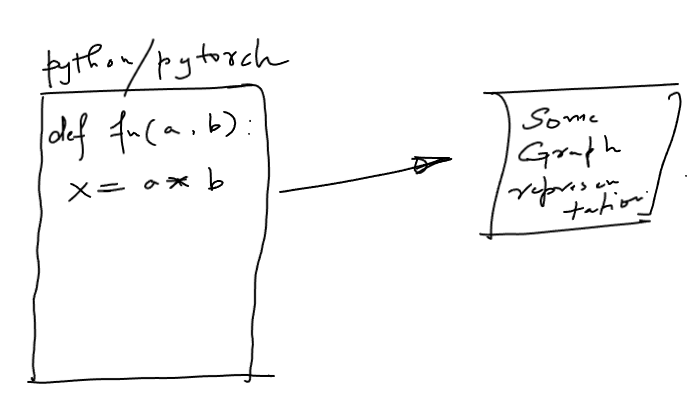

Ideally we would like to get a graph/IR representation out of the python program which we write. But static analysis of python code is very difficult.

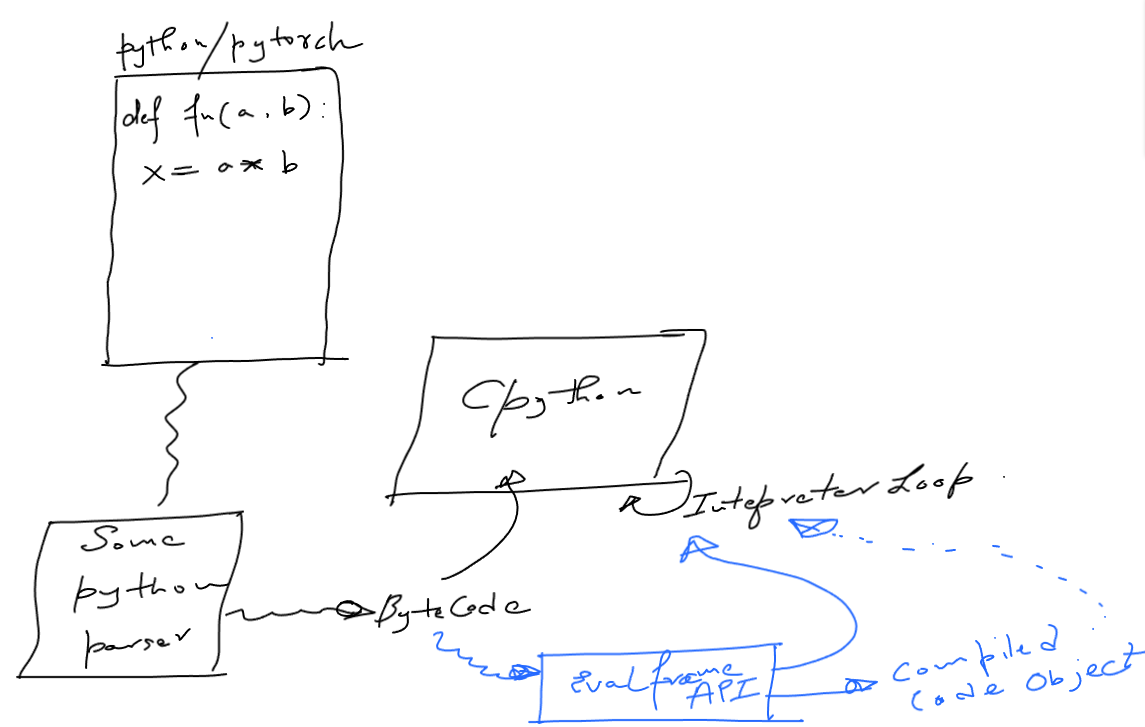

The approach which they use is through a new CPython API which was made available in the Python Enhancement Proposal 523. That API is called PythonEvalFrame.

This is how it works:
- Basic flow is, the python program in a .py file is parsed by some parser and the corresponding bytecode is produced. (Why this approach, let's not go into the details, but in short to support various python interpreters I guess.)
- Then we feed in each bytecode into the CPython Interpreter loop.
- The CPython API dicussed above helps us to intercept in between this submission of bytecode to the Cpython interpreter.
- Using that CPython API, you can write custom logic to modify bytecode before passing it on the CPython interpreter.
- Also an important point is, you can modify the byte code to make calls to already compiled object code.

TorchDynamo makes it easy to experiment with different compiler backends to make PyTorch code faster with a single line decorator `torch._dynamo.optimize()` which is wrapped for convenience by `torch.compile()`

The following diagram demonstrates how PyTorch works with `torch.compile` and without it:
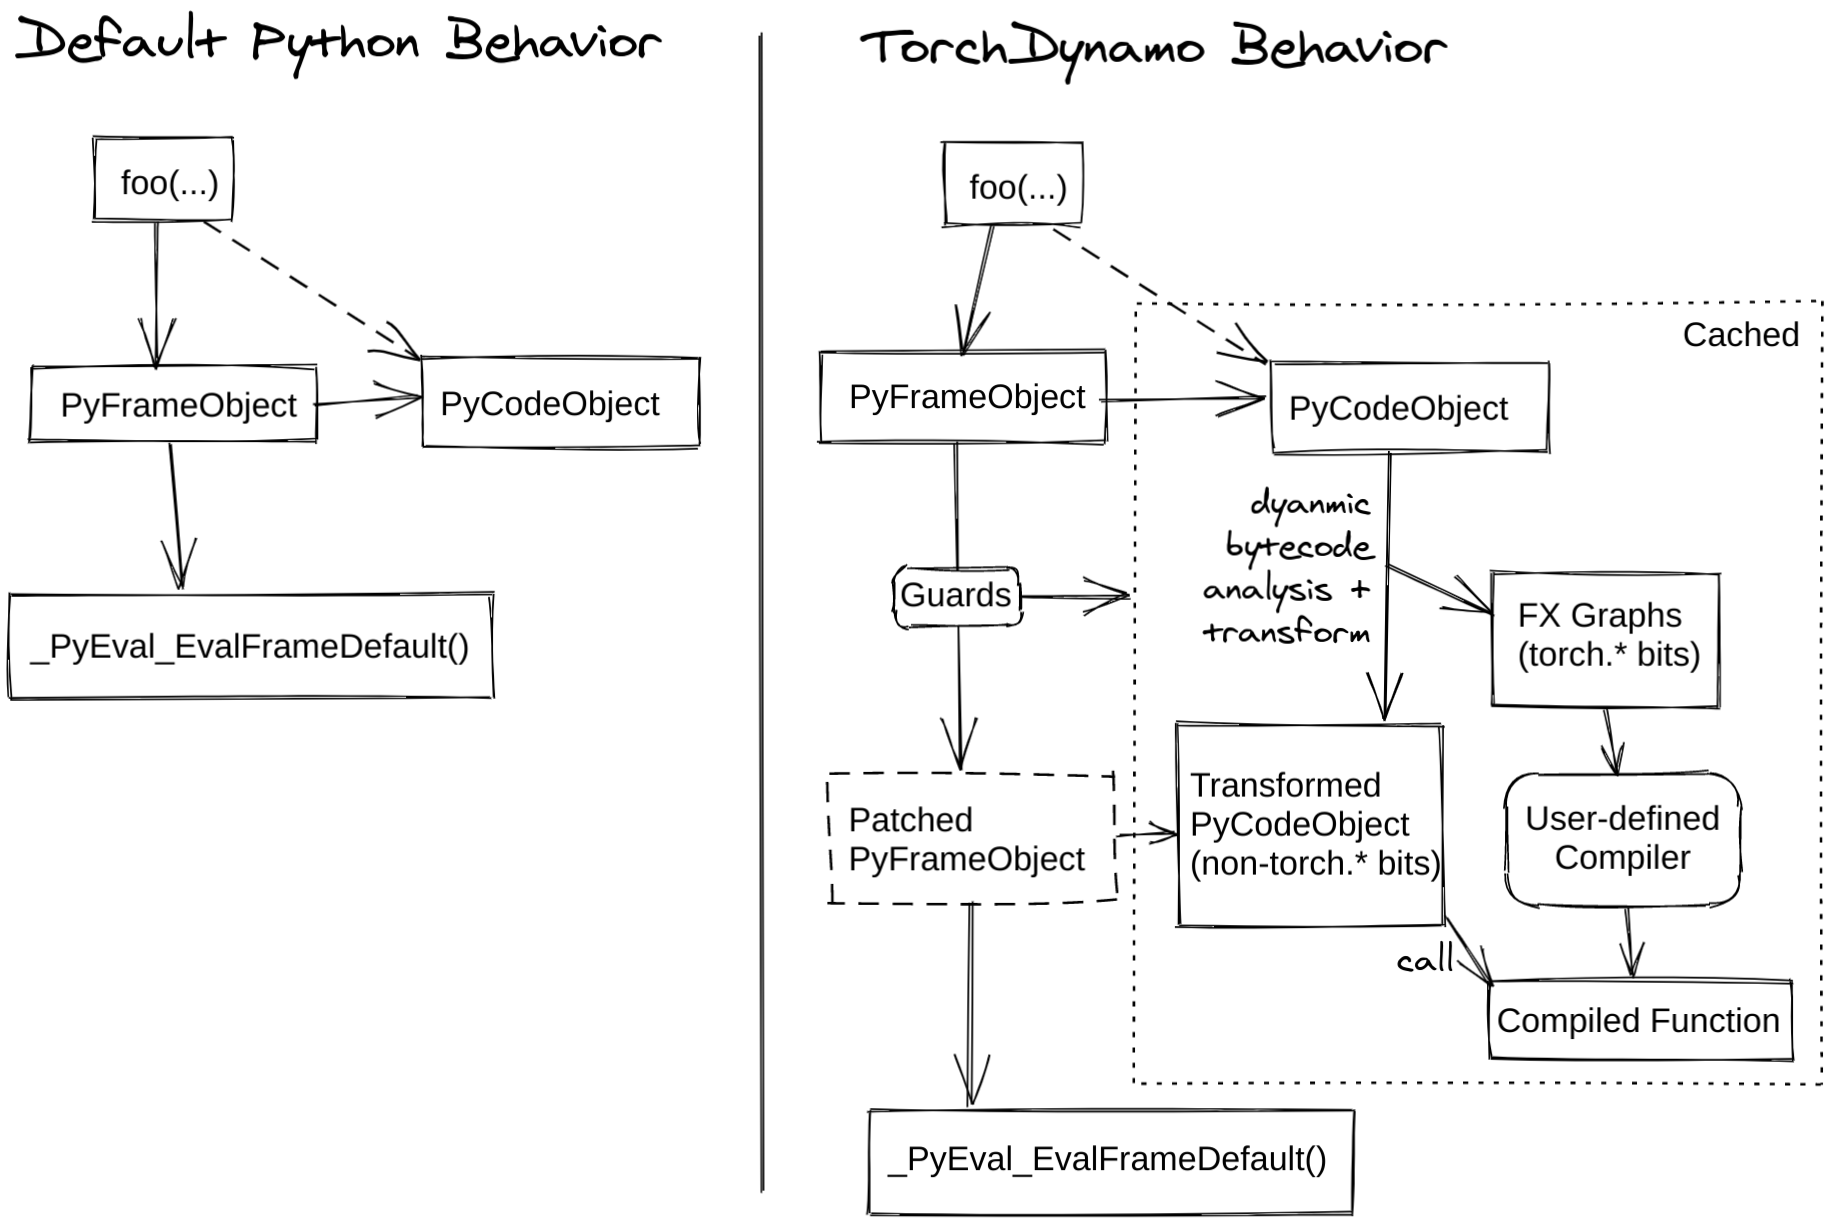

RESET IPYNB KERNEL HERE

In [1]:
import os
os.environ['TORCH_LOGS'] = "+dynamo,guards,bytecode"

If you are not familiar with Python bytecode, you can add a decompiler hook to decompile the bytecode into human-readable source code. One available tool is depyf.

In [2]:
import depyf
depyf.install()

Dynamo is a Front-end. To just demonstrate what is happening in TorchDynamo FrontEnd, we just use a dummy compiler backend, at the Torch IR level. (Things shall get clearer as we move along and look at the PT2 backend integration)

In [3]:
from typing import List
import torch
from torch import _dynamo as torchdynamo
def my_compiler(gm: torch.fx.GraphModule, example_inputs: List[torch.Tensor]):
    print("my_compiler() called with FX graph:")
    gm.graph.print_tabular()
    return gm.forward  # return a python callable

@torchdynamo.optimize(my_compiler)
def toy_example(a, b):
    x = a / (torch.abs(a) + 1)
    if b.sum() < 0:
        b = b * -1
    return x * b
for _ in range(100):
    toy_example(torch.randn(10), torch.randn(10))

V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0] torchdynamo start compiling toy_example /tmp/ipykernel_711767/4154601551.py:9, stack (elided 6 frames):
V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0]   File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0]     return _run_code(code, main_globals, None,
V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0]   File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0]     exec(code, run_globals)
V0613 01:59:47.233000 140497701302272 torch/_dynamo/convert_frame.py:758] [0/0]   File "/media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
V0613 01:59:47.233000 140497701302272 torch

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$source=LocalSource(local_name='a', cell_or_freevar=False), type(source)=<class 'torch._dynamo.source.LocalSource'>, source.name()="L['a']"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$source=LocalSource(local_name='b', cell_or_freevar=False), type(source)=<class 'torch._dynamo.source.LocalSource'>, source.name()="L['b']"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
my_compiler() called with FX graph:
opcode         name    target                                                  args         kwargs    meta
-------------  ------  ------------------------------------------------------  -----------  --------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The original forward method was:
```py
def toy_example(a, b):
    x = a / (torch.abs(a) + 1)
    if b.sum() < 0:
        b = b * -1
    return x * b
```

The debug messages above generated the following  `__compiled_fn_1`
```py
 ===== __compiled_fn_1 =====
 /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/torch/fx/_lazy_graph_module.py class GraphModule(torch.nn.Module):
    def forward(self, L_a_: "f32[10]", L_b_: "f32[10]"):
        l_a_ = L_a_
        l_b_ = L_b_
        
        # File: /tmp/ipykernel_692535/4154601551.py:11 in toy_example, code: x = a / (torch.abs(a) + 1)
        abs_1: "f32[10]" = torch.abs(l_a_)
        add: "f32[10]" = abs_1 + 1;  abs_1 = None
        x: "f32[10]" = l_a_ / add;  l_a_ = add = None
        
        # File: /tmp/ipykernel_692535/4154601551.py:12 in toy_example, code: if b.sum() < 0:
        sum_1: "f32[]" = l_b_.sum();  l_b_ = None
        lt: "b8[]" = sum_1 < 0;  sum_1 = None
        return (x, lt)
```

Note that FxGraphs cannot deal with dynamic control flows. So Dynamo introduces a FX Graph break at the `if b.sum() < 0:` statment.
This compiled function basically returns the `x = a / (torch.abs(a)+1)` and `b.sum() < 0` conditional decision as a tuple.

You might be curious of what happens if we just pass the forward method as shown above through FXGraph Legacy trace? It causes error

In [4]:
import torch
import torch.fx

def toy_example(a, b):
    x = a / (torch.abs(a) + 1)
    if b.sum() < 0:
        b = b * -1
    return x * b

traced_module = torch.fx.symbolic_trace(toy_example)
print(traced_module)

_fn(args= (<torch.fx._symbolic_trace.Tracer object at 0x7fc72988ca00>, <function toy_example at 0x7fc75054c940>, None), kwargs= {}


TraceError: symbolically traced variables cannot be used as inputs to control flow

In the above example we also see something as the modified byte code (the corresponding python source code of it by depyf)
```py
# possible source code:
 def toy_example(a, b):
     __temp_2, __temp_3 = __compiled_fn_1(a, b)
     x = __temp_2
     if __temp_3:
         return __resume_at_30_2(b, x)
     return __resume_at_38_3(b, x)
```

In the modified bytecode, `__compiled_fn_1` is the return value of `my_compiler()` (the compiled graph). `__resume_at_30_2` and `__resume_at_38_3` are both generated continuation functions that pick up execution after a graph break (at bytecode offsets 30 and 38). Each of these functions take the form:

```py
__resume_at_<offset>:
    ... restore stack state if needed ...
    JUMP_ABSOLUTE <offset> into toy_example
    ... original bytecode of toy_example ...
```
By generating this resume_at function, we force the remainder of the function to be executed in a new Python frame which recursively triggers TorchDynamo to restart its capture once execution reaches that point for the first time.

Let us have a look at the source of the `__resume_at_30_2` and `__resume_at_38_3` function

In [5]:
print("source code of __resume_at_30_2:")
print(depyf.decompile(__resume_at_30_2))

source code of __resume_at_30_2:
def torch_dynamo_resume_in_toy_example_at_12(b, x):
    b = b * -1
    return x * b



In [6]:
print("source code of __resume_at_38_3:")
print(depyf.decompile(__resume_at_38_3))

source code of __resume_at_38_3:
def torch_dynamo_resume_in_toy_example_at_12(b, x):
    return x * b



Dynamo restarts its capture for `__resume_at_30_2` and we get a compiled function as:

```py
 TRACED GRAPH
  ===== __compiled_fn_7 =====
  /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/torch/fx/_lazy_graph_module.py class GraphModule(torch.nn.Module):
     def forward(self, L_b_: "f32[10]", L_x_: "f32[10]"):
         l_b_ = L_b_
         l_x_ = L_x_
         
         # File: /tmp/ipykernel_692535/4154601551.py:13 in torch_dynamo_resume_in_toy_example_at_12, code: b = b * -1
         b: "f32[10]" = l_b_ * -1;  l_b_ = None
         
         # File: /tmp/ipykernel_692535/4154601551.py:14 in torch_dynamo_resume_in_toy_example_at_12, code: return x * b
         mul_1: "f32[10]" = l_x_ * b;  l_x_ = b = None
         return (mul_1,)
```
And the modified byte code becomes (showing depyf reconstruction):

```py
#possible source code:
 def torch_dynamo_resume_in_toy_example_at_12(b, x):
     return __compiled_fn_7(b, x)
```

Similarly Dynamo restarts its capture for `__resume_at_38_3` and we get a compiled function as:

```py
TRACED GRAPH
===== __compiled_fn_5 =====
  /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/torch/fx/_lazy_graph_module.py class GraphModule(torch.nn.Module):
     def forward(self, L_x_: "f32[10]", L_b_: "f32[10]"):
         l_x_ = L_x_
         l_b_ = L_b_
         
         # File: /tmp/ipykernel_692535/4154601551.py:14 in torch_dynamo_resume_in_toy_example_at_12, code: return x * b
         mul: "f32[10]" = l_x_ * l_b_;  l_x_ = l_b_ = None
         return (mul,)
```

And the modified byte code becomes (showing depyf reconstruction):
```py
# possible source code:
 def torch_dynamo_resume_in_toy_example_at_12(b, x):
     return __compiled_fn_5(x, b)

```

### A brief on Guard

```py
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2172] [0/0] [__guards] GUARDS:
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] 
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] TREE_GUARD_MANAGER:
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] +- RootGuardManager
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | +- DEFAULT_DEVICE: utils_device.CURRENT_DEVICE == None                           # _dynamo/output_graph.py:459 in init_ambient_guards
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | +- GLOBAL_STATE: ___check_global_state()
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | +- GuardManager: source=L['a'], accessed_by=DictGetItemGuardAccessor(a)
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- TENSOR_MATCH: check_tensor(L['a'], Tensor, DispatchKeySet(CPU, BackendSelect, ADInplaceOrView, AutogradCPU), torch.float32, device=None, requires_grad=False, size=[10], stride=[1])  # x = a / (torch.abs(a) + 1)  # mp/ipykernel_692535/4154601551.py:11 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- NO_HASATTR: hasattr(L['a'], '_dynamo_dynamic_indices') == False           # x = a / (torch.abs(a) + 1)  # mp/ipykernel_692535/4154601551.py:11 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- NO_TENSOR_ALIASING: check_no_aliasing(L['a'], L['b'])
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | +- GuardManager: source=L['b'], accessed_by=DictGetItemGuardAccessor(b)
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- TENSOR_MATCH: check_tensor(L['b'], Tensor, DispatchKeySet(CPU, BackendSelect, ADInplaceOrView, AutogradCPU), torch.float32, device=None, requires_grad=False, size=[10], stride=[1])  # if b.sum() < 0:  # mp/ipykernel_692535/4154601551.py:12 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- NO_HASATTR: hasattr(L['b'], '_dynamo_dynamic_indices') == False           # if b.sum() < 0:  # mp/ipykernel_692535/4154601551.py:12 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- NO_TENSOR_ALIASING: check_no_aliasing(L['a'], L['b'])
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | +- GuardManager: source=G, accessed_by=GlobalsGuardAccessor
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | +- GuardManager: source=G['torch'], accessed_by=DictGetItemGuardAccessor(torch)
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | | +- ID_MATCH: ___check_obj_id(G['torch'], 140117675359296)                  # x = a / (torch.abs(a) + 1)  # mp/ipykernel_692535/4154601551.py:11 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | | +- GuardManager: source=G['torch'].abs, accessed_by=GetAttrGuardAccessor(abs)
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards] | | | | +- ID_MATCH: ___check_obj_id(G['torch'].abs, 140117675967408)              # x = a / (torch.abs(a) + 1)  # mp/ipykernel_692535/4154601551.py:11 in toy_example
V0611 21:51:25.083000 140117874032640 torch/_dynamo/guards.py:2151] [0/0] [__guards]
```

If any of those guards fail, the graph will be recaptured and recompiled. The interesting guard there is `check_tensor`, which checks the following `torch.Tensor` properties:
- Python class of the tensor (tensor subclassing, etc)
- dtype
- device
- requires_grad
- dispatch_key (with thread-local includes/excludes applied)
- ndim
- sizes*
- strides*

Argument `L` of the guard function. This is a dict mapping the name of arguments of `toy_example` to its values. This is only available when the function is called, where the frame evaluation API comes into play. In short, `L` is a dict with structure of `{'a': value_a, 'b': value_b}`. Therefore, you can see the code uses `L['a']` to refer to the input variable `a`.

To summarize, the compiled code is conceptually equivalent to the code below:

```py
def compiled_example(a, b):
    L = {'a': a, 'b': b}
    for guard, code in get_cache_entries():
        if guard(L):
            return code(a, b)
    recompile_and_add_another_cache_entry()
```
The following diagram demonstrates how torch.compile transforms and optimizes user-written code: it first extracts computation graphs from the user-written function, and compiles these graphs into optimized functions, then assembles them into a new function, which is functionally equivalent to the user-written code but optimized to have a good computation speed.

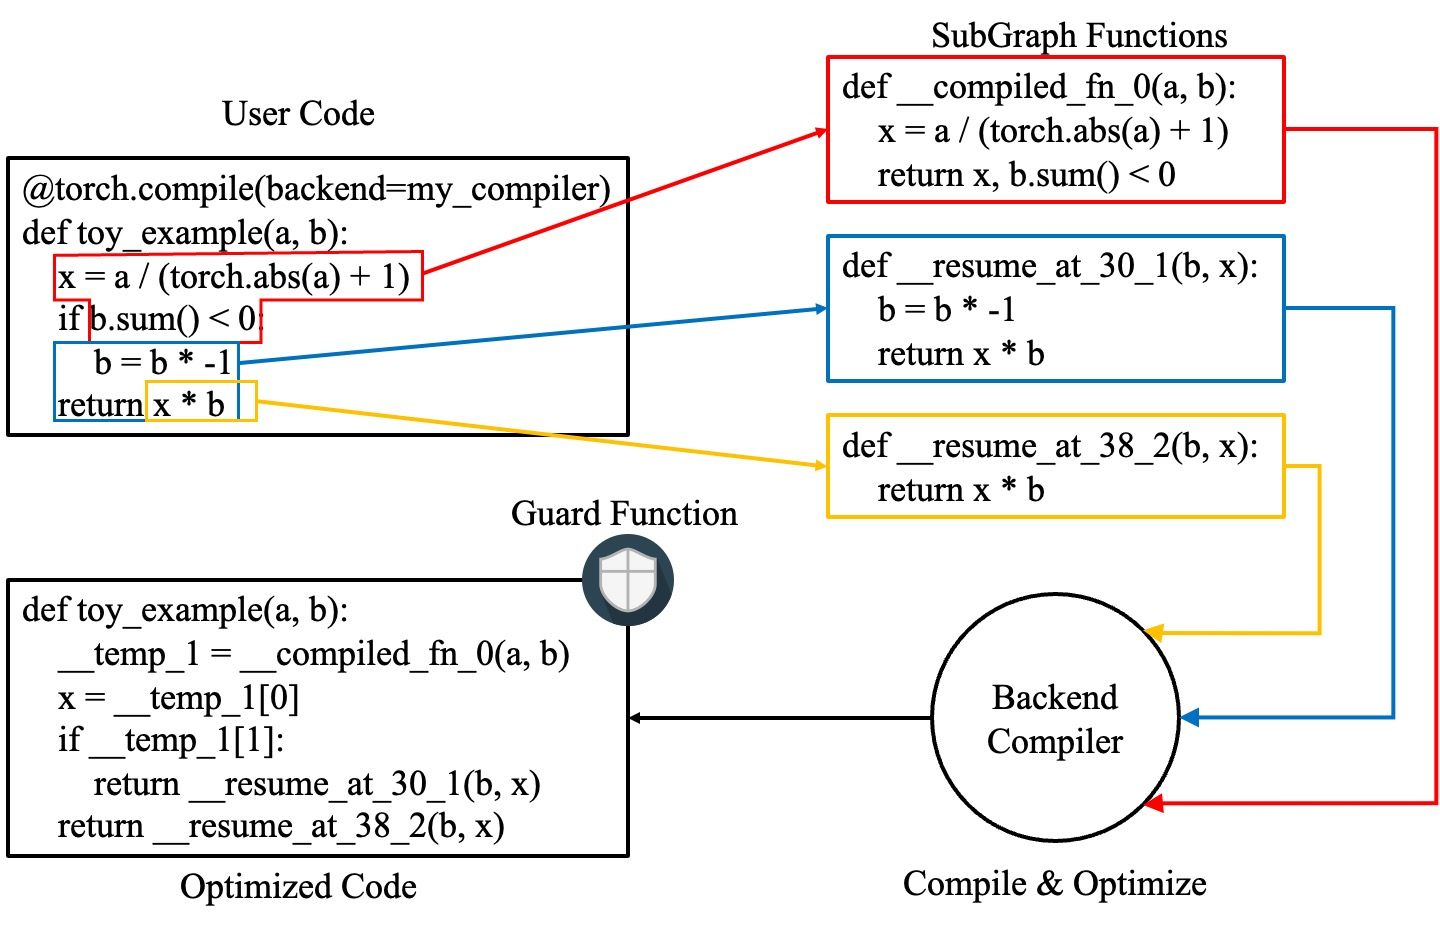

# PT2 Backend Integration and Torch Inductor Deep Dive

At a high-level the default options for PyTorch 2.0 deep learning compiler performs the following key tasks:

- **Graph capture**: Computational graph representation for your models and functions. 
    - PyTorch technologies: TorchDynamo, Torch FX, FX IR. (We have dealt with this in the TorchDynamo Section)
- **Automatic differentiation**: Backward graph tracing using automatic differentiation and lowering to primitives operators. 
    - PyTorch technologies: AOTAutograd, Aten IR
- **Optimizations**: Forward and backward graph-level optimizations and operator fusion. 
    - PyTorch technologies: TorchInductor (default) or other compilers
- **Code generation**: Generating hardware specific C++/GPU Code. 
    - PyTorch technologies: TorchInductor, OpenAI Triton (default) other compilers

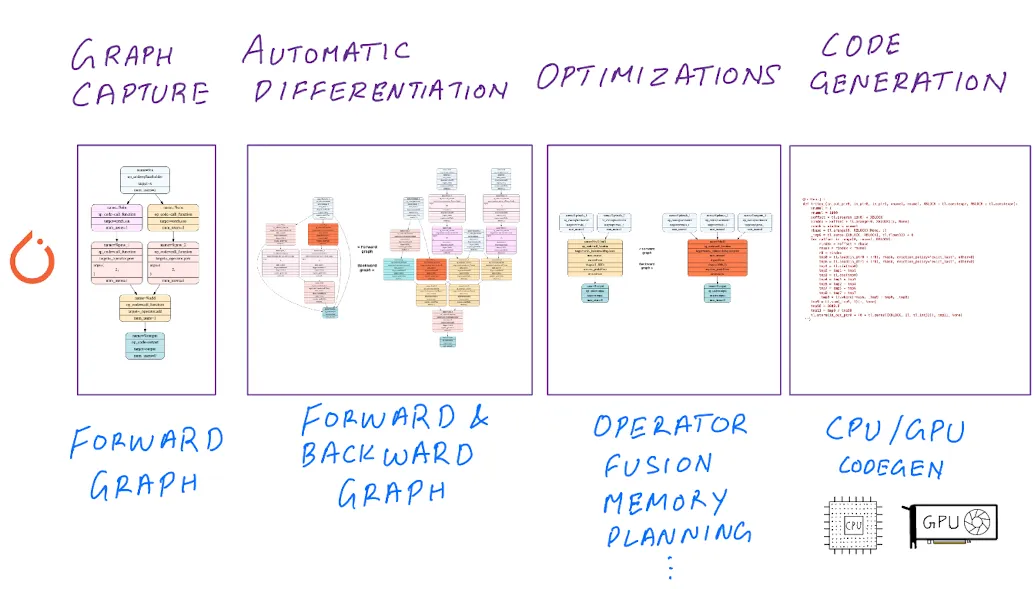

For the sake of simplicity, let's define a very simple function and run it through the PT2 stack. 

NOTE: You can replace this function with a deep neural network model or an `nn.Module` subclass, but this example should help you appreciate what’s going on under the hood much better than a complex multi-million parameter model. 

RESTART IPYNB NOTEBOOK HERE.

In [1]:
import torch
import math
import os
import matplotlib.pyplot as plt
import torch._dynamo
from torchvision import models
from torch.fx.passes.graph_drawer import FxGraphDrawer
from IPython.display import Markdown as md

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
def f(x):
    return torch.sin(x)**2 + torch.cos(x)**2

md('''
# $ y = f(x) = sin^2(x) + cos^2(x)$
''')


# $ y = f(x) = sin^2(x) + cos^2(x)$


We take dummy compiler backend named `inspect_backend`. It just needs to follow the protocol, that it takes in a GraphModule (generated by TorchDynamo, basically Torch IR) and sample_inputs.

The function `inspect_backend` if it has to act like a backend compiler, has to call the `return gm.forward` as a part of the protocol.

In [3]:
def inspect_backend(gm, sample_inputs):
    code = gm.print_readable()
    with open("forward.svg", "wb") as file:
        file.write(FxGraphDrawer(gm,'f').get_dot_graph().create_svg())
    return gm.forward

torch._dynamo.reset()
compiled_f = torch.compile(f, backend=inspect_backend)

x = torch.rand(1000, requires_grad=True).to(device)
out = compiled_f(x)

md(f'''
### Graph
![]({'forward.svg'})
''')

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$source=LocalSource(local_name='x', cell_or_freevar=False), type(source)=<class 'torch._dynamo.source.LocalSource'>, source.name()="L['x']"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
class GraphModule(torch.nn.Module):
    def forward(self, L_x_: "f32[1000]"):
        l_x_ = L_x_
        
        # File: /tmp/ipykernel_711820/1097326487.py:2 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        sin: "f32[1000]" = torch.sin(l_x_)
        pow_1: "f32[1000]" = sin ** 2;  sin = None
        cos: "f32[1000]" = torch.cos(l_x_);  l_x_ = None
        pow_2: "f32[1000]" = cos ** 2;  cos = None
        add: "f32[1000]" = pow_1 + pow_2;  pow_1 = pow_2 = None
        return (add,)
        
type(codegen)=<class 'torch._dynamo.codegen.PyCodegen'>, codegen=<torch._dynamo.codegen.PyCodegen object at 0x7ff9c66b3490>
type(self.guard_manager)=<class 'torch._dynamo.guards.GuardManager'>
_fn(args= (tensor([6.5187e-01, 3.4456e-01, 1.9695e-01, 3.8392e-01, 1.9421e-02,


### Graph
![](forward.svg)


As we have already seen, but let's recap, the Torch IR received is:

```py
class GraphModule(torch.nn.Module):
    def forward(self, L_x_: "f32[1000]"):
        l_x_ = L_x_
        
        # File: /tmp/ipykernel_702509/1097326487.py:2 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        sin: "f32[1000]" = torch.sin(l_x_)
        pow_1: "f32[1000]" = sin ** 2;  sin = None
        cos: "f32[1000]" = torch.cos(l_x_);  l_x_ = None
        pow_2: "f32[1000]" = cos ** 2;  cos = None
        add: "f32[1000]" = pow_1 + pow_2;  pow_1 = pow_2 = None
        return (add,)
```

And the same if we wanna see graphically, (the above graph annotated with what they do):

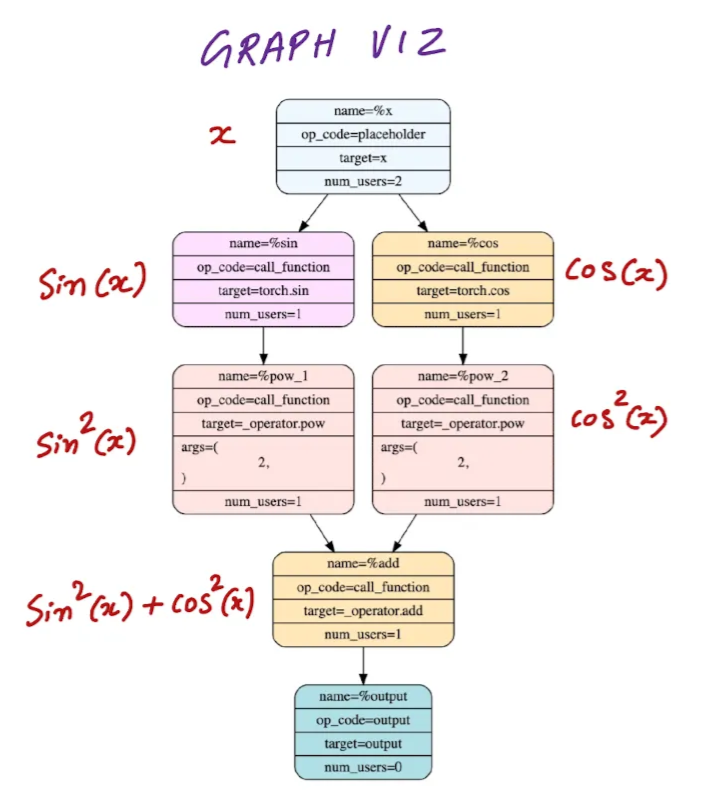

### Automatic differentiation: Forward and backward computational graphs (AOTAutograd)

TorchDynamo gave us the forward pass function evaluation as an FX graph, but what about the backward pass?

In [4]:
md('''
# **Forward graph:** $f(x) = sin^2(x)+cos^2(x)$ \n
# **Backward graph:** $\\frac {df(x)}{d\\vec{x}} = f\'(x) = 2sin(x)cos(x) + 2cos(x)(-sin(x))$
''')


# **Forward graph:** $f(x) = sin^2(x)+cos^2(x)$ 

# **Backward graph:** $\frac {df(x)}{d\vec{x}} = f'(x) = 2sin(x)cos(x) + 2cos(x)(-sin(x))$


PyTorch uses reverse-mode automatic differentiation to compute the gradients, and PyTorch’s implementation of automation differentiation is called Autograd. PT2 introduces **AOTAutograd** which traces the forward and backward graph ahead of time, i.e. prior to execution, and generates a joint forward and backward graph. 

It then partitions the forward and the backward graph into two separate graphs. Both the forward and the backward graphs are stored in the FX graph data structure and can be visualized as shown below.

We’ll now run AOTAutograd by extending our fake compiler function `inspect_backend` to call AOTAutograd and generate our backward graph. The updated inspect_backed defines a **forward (fw)** and **backward (bw)** compiler capture function that reads the forward and backward graph from AOTAutograd and prints the lowered ATen IR and saves the FX graph for the forward and backward graphs.

#### AOTAutograd and ATen IR

In [5]:
import torch._dynamo
from torch.fx.passes.graph_drawer import FxGraphDrawer
from functorch.compile import make_boxed_func
from torch._functorch.aot_autograd import aot_module_simplified

def f(x):
    return torch.sin(x)**2 + torch.cos(x)**2

def inspect_backend(gm, sample_inputs): 
    # Forward compiler capture
    def fw(gm, sample_inputs):
        gm.print_readable()
        print("Notice that sample_inputs is a list of flattened FakeTensor:")
        print(sample_inputs)
        g = FxGraphDrawer(gm, 'fn')
        with open("forward_aot.svg", "wb") as file:
            file.write(g.get_dot_graph().create_svg())
        return make_boxed_func(gm.forward)
    
    # Backward compiler capture
    def bw(gm, sample_inputs):
        gm.print_readable()
        print("Notice that sample_inputs is a list of flattened FakeTensor:")
        print(sample_inputs)
        g = FxGraphDrawer(gm, 'fn')
        with open("backward_aot.svg", "wb") as file:
            file.write(g.get_dot_graph().create_svg())
        return make_boxed_func(gm.forward)
    
    # Call AOTAutograd
    gm_forward = aot_module_simplified(gm,sample_inputs,
                                       fw_compiler=fw,
                                       bw_compiler=bw)

    return gm_forward

torch.manual_seed(0)
x = torch.rand(1000, requires_grad=True).to(device)
y = torch.ones_like(x)

torch._dynamo.reset()
compiled_f = torch.compile(f, backend=inspect_backend)
out = torch.nn.functional.mse_loss(compiled_f(x), y).backward()

_fn(args= (0,), kwargs= {}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$source=LocalSource(local_name='x', cell_or_freevar=False), type(source)=<class 'torch._dynamo.source.LocalSource'>, source.name()="L['x']"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
_fn(args= (<function create_functionalized_fn.<locals>.joint_helper at 0x7ff9c64f6cb0>,), kwargs= {'tracer': <torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7ff9c65246a0>, 'concrete_args': ([PH], [PH])}
_fn(args= (<torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7ff9c65246a0>, <function create_functionalized_fn.<locals>.joint_helper at 0x7ff9c64f6cb0>, ([PH], [PH])), kwargs= {}
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[1000]"):
        # File: /tmp/ipykernel_711820/422412477.py:7 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        sin: "f32[1000]" = torch.ops.aten.sin.default(primals_1)
        pow_1: "f32[1000]" = torch.ops.aten.pow.Tensor_Scalar(sin, 2)
        cos: "f32[1

In [6]:
md(f'''
|![]({'forward_aot.svg'}) | < Forward graph <br><br><br> Backward graph >|![]({'backward_aot.svg'})|
|---|---|---|
''')


|![](forward_aot.svg) | < Forward graph <br><br><br> Backward graph >|![](backward_aot.svg)|
|---|---|---|


The above two graphs with annotations (CHANGE THE PICTURE):


| FORWARD GRAPH AOT |  | BACKWARD GRAPH AOT |
| -------- | -------- | -------- |
| |    | 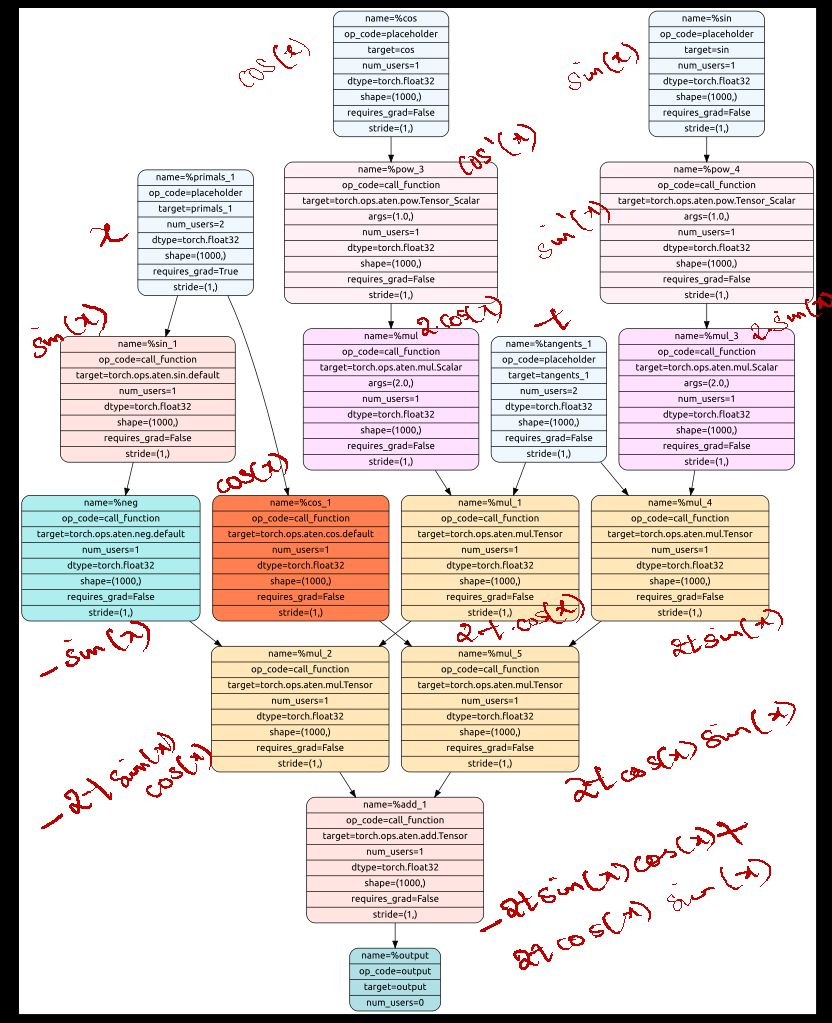  |


This will generate the following forward AND backward graphs. Notice that the forward graph also looks slightly different from what we saw earlier. For example `torch.sin(x)` in the FX graph IR and in our original code has been replaced by `torch.ops.aten.sin.default()`. 

What’s this funny thing called `aten`, you might ask, if you’re not already familiar with it. **ATen stands for A Tensor library**, which is a very creatively named low level library with a C++ interface that implements many of the fundamental operations that run on CPU and GPU.

In eager mode operation, our PyTorch operations are routed to this library which then calls the appropriate CPU or GPU implementation. **AOTAutograd** automatically generates code that replaces the higher level PyTorch API with **ATen IR** for the forward and backward graph which you can see in the output below:

```py
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[1000]"):
        # File: /tmp/ipykernel_702509/422412477.py:7 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        sin: "f32[1000]" = torch.ops.aten.sin.default(primals_1)
        pow_1: "f32[1000]" = torch.ops.aten.pow.Tensor_Scalar(sin, 2)
        cos: "f32[1000]" = torch.ops.aten.cos.default(primals_1)
        pow_2: "f32[1000]" = torch.ops.aten.pow.Tensor_Scalar(cos, 2)
        add: "f32[1000]" = torch.ops.aten.add.Tensor(pow_1, pow_2);  pow_1 = pow_2 = None
        return [add, primals_1, sin, cos]
```

```py
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[1000]", sin: "f32[1000]", cos: "f32[1000]", tangents_1: "f32[1000]"):
        # File: /tmp/ipykernel_702509/422412477.py:7 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        pow_3: "f32[1000]" = torch.ops.aten.pow.Tensor_Scalar(cos, 1.0);  cos = None
        mul: "f32[1000]" = torch.ops.aten.mul.Scalar(pow_3, 2.0);  pow_3 = None
        mul_1: "f32[1000]" = torch.ops.aten.mul.Tensor(tangents_1, mul);  mul = None
        sin_1: "f32[1000]" = torch.ops.aten.sin.default(primals_1)
        neg: "f32[1000]" = torch.ops.aten.neg.default(sin_1);  sin_1 = None
        mul_2: "f32[1000]" = torch.ops.aten.mul.Tensor(mul_1, neg);  mul_1 = neg = None
        pow_4: "f32[1000]" = torch.ops.aten.pow.Tensor_Scalar(sin, 1.0);  sin = None
        mul_3: "f32[1000]" = torch.ops.aten.mul.Scalar(pow_4, 2.0);  pow_4 = None
        mul_4: "f32[1000]" = torch.ops.aten.mul.Tensor(tangents_1, mul_3);  tangents_1 = mul_3 = None
        cos_1: "f32[1000]" = torch.ops.aten.cos.default(primals_1);  primals_1 = None
        mul_5: "f32[1000]" = torch.ops.aten.mul.Tensor(mul_4, cos_1);  mul_4 = cos_1 = None
        
        # File: /tmp/ipykernel_702509/422412477.py:7 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
        add_1: "f32[1000]" = torch.ops.aten.add.Tensor(mul_2, mul_5);  mul_2 = mul_5 = None
        return [add_1]
```

You can also see that in addition to the output of the forward pass, the forward graph outputs some additional tensors [add, sin, cos, primals_1] . These tensors are saved for the backward pass for gradient calculation. 

### What are the different types of IR in PyTorch?
**ATen IR** is a list of operators supported by the ATen library as we discussed in the previous section, and you can see the full list of operations implemented in ATen library.

There are two other IR concepts in PyTorch you should be aware of: 
1. Core Aten IR 
2. Prims IR. 

Core Aten IR is a subset of the broader Aten IR and Prims IR and an even smaller subset of Core Aten IR. 

Let’s say you are designing a processor and want to support PyTorch code acceleration on your hardware. It’d be near impossible to support the full list of PyTorch API in hardware, so what you can do is build a compiler that only supports the smaller subset of fundamental operators defined in Core Aten IR or Prims IR, and let AOTAutograd decompose compound operators into the core operators.

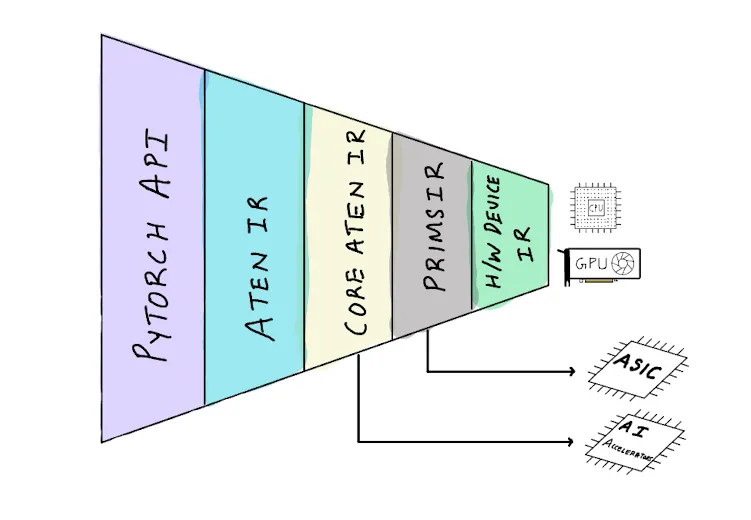

### Graph optimization: Layer and operator fusion and C++/GPU code generation


The computational graph from the output of AOTAutograd in the previous section is composed of many Aten operators represented in an FX graph. TorchInductor optimizations doesn’t change the underlying computation in the graph but merely restructures it with operator and layer fusion, and generates CPU or GPU code for it. Since TorchInductor can see the full forward and backward computational graph ahead of time, it can take decisions on out-of-order execution of operations that don’t have dependence on each other, and maximize hardware resource utilization.

Under the hood, for GPU targets, TorchInductor uses **OpenAI’s Triton** to generate fused GPU kernels. Triton itself is a separate Python based framework and compiler for writing optimized low-level GPU code which is otherwise written in CUDA C/C++. But the only difference is that TorchInductor will generate Triton code which is compiled into low level PTX code.

For multi-core CPU targets, TorchInductor generates C++ code and injects OpenMP pragma directives to generate parallel kernels. From the PyTorch user level world view, this is the IR transformation flow:

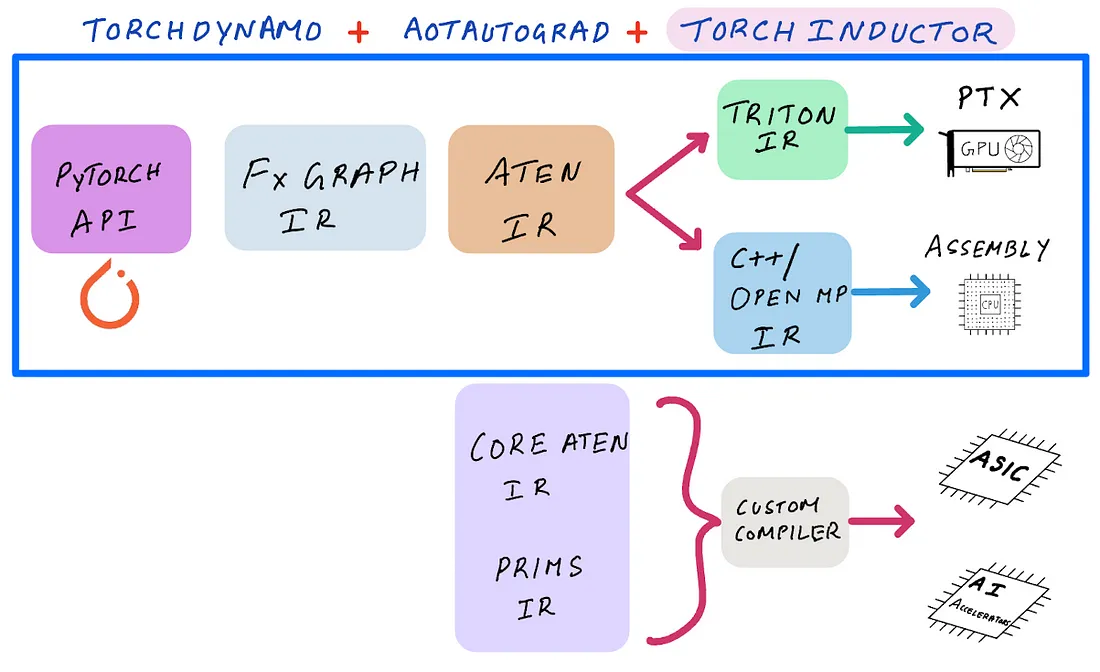

Note that TorchInductor takes in inputs in **ATen IR**.

We’ll now throw away our fake compiler which we used in our previous section, and use the full PyTorch compiler stack that uses TorchInductor.

RESET IPYNB NOTEBOOK HERE

In [1]:
import os
os.environ['TORCH_LOGS'] = "+dynamo,guards,bytecode,+inductor"

In [2]:
import torch
def f(x):
    return torch.sin(x)**2 + torch.cos(x)**2 

torch._dynamo.reset()
compiled_f = torch.compile(f, backend='inductor',
                              options={'trace.enabled':True,
                                       'trace.graph_diagram':True})


# device = 'cpu'
device = 'cuda'

torch.manual_seed(0)
x = torch.rand(1000, requires_grad=True).to(device)
y = torch.ones_like(x)

out = torch.nn.functional.mse_loss(compiled_f(x),y).backward()

V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0] torchdynamo start compiling f /tmp/ipykernel_711894/2967604626.py:2, stack (elided 6 frames):
V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0]   File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0]     return _run_code(code, main_globals, None,
V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0]   File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0]     exec(code, run_globals)
V0613 02:05:47.303000 140042118017024 torch/_dynamo/convert_frame.py:758] [0/0]   File "/media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
V0613 02:05:47.303000 140042118017024 torch/_dynamo/c

_fn(args= (0,), kwargs= {}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$source=LocalSource(local_name='x', cell_or_freevar=False), type(source)=<class 'torch._dynamo.source.LocalSource'>, source.name()="L['x']"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
opcode         name    target                                                  args            kwargs    meta
-------------  ------  ------------------------------------------------------  --------------  --------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
placeholder    l_x_ 

I0613 02:05:47.751000 140042118017024 torch/_dynamo/logging.py:55] [0/0] Step 3: torchinductor compiling FORWARDS graph 0
V0613 02:05:47.770000 140042118017024 torch/_inductor/compile_fx.py:718] [0/0] [__post_grad_graphs] TRACED GRAPH
V0613 02:05:47.770000 140042118017024 torch/_inductor/compile_fx.py:718] [0/0] [__post_grad_graphs]  ===== AFTER POST GRAD =====
V0613 02:05:47.770000 140042118017024 torch/_inductor/compile_fx.py:718] [0/0] [__post_grad_graphs]  /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-venv-front-end/lib/python3.10/site-packages/torch/fx/_lazy_graph_module.py class GraphModule(torch.nn.Module):
V0613 02:05:47.770000 140042118017024 torch/_inductor/compile_fx.py:718] [0/0] [__post_grad_graphs]     def forward(self, primals_1: "f32[1000]"):
V0613 02:05:47.770000 140042118017024 torch/_inductor/compile_fx.py:718] [0/0] [__post_grad_graphs]         # File: /tmp/ipykernel_711894/2967604626.py:3 in f, code: return torch.sin(x)**2 + torch.cos(x)**2
V0

_fn(args= (<function _misc_patterns_init.<locals>.randperm_index_add_pattern at 0x7f5d00092830>,), kwargs= {'tracer': <torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7f5d000a9db0>, 'concrete_args': (PH, PH)}
_fn(args= (<torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7f5d000a9db0>, <function _misc_patterns_init.<locals>.randperm_index_add_pattern at 0x7f5d00092830>, (PH, PH)), kwargs= {}
_fn(args= (<function _misc_patterns_init.<locals>.randperm_index_pattern at 0x7f5d000bc310>,), kwargs= {'tracer': <torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7f5d000ab820>, 'concrete_args': (PH, PH)}
_fn(args= (<torch.fx.experimental.proxy_tensor.PythonKeyTracer object at 0x7f5d000ab820>, <function _misc_patterns_init.<locals>.randperm_index_pattern at 0x7f5d000bc310>, (PH, PH)), kwargs= {}
Entering
V=<torch._inductor.virtualized._V object at 0x7f5d3c085090> VVVVVVVVVVVVVVV
opcode         name       target                  args                 kwargs  

I0613 02:05:48.799000 140042118017024 torch/_inductor/debug.py:470] [0/0] Writing debug ir to  /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-front-end-analysis/PT2.0-general-talk/torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_forward_1.0/ir_post_fusion.txt
V0613 02:05:48.889000 140042118017024 torch/_inductor/scheduler.py:2717] [0/0] Generating code for node buf0 with estimated runtime 17.857143
V0613 02:05:48.893000 140042118017024 torch/_inductor/codegen/simd.py:1305] [0/0] Generating kernel code with kernel_name: triton_poi_fused_add_cos_pow_sin_0
V0613 02:05:48.914000 140042118017024 torch/_inductor/runtime/triton_heuristics.py:195] [0/0] CachingAutotuner gets 1 configs for triton_
V0613 02:05:48.915000 140042118017024 torch/_inductor/runtime/triton_heuristics.py:201] [0/0] XBLOCK: 128, num_warps: 4, num_ctas: 1, num_stages: 1
V0613 02:05:48.938000 140042118017024 torch/_inductor/runtime/triton_heuristics.py:195] CachingAu

Writing FX graph to file: /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-front-end-analysis/PT2.0-general-talk/torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_forward_1.0/graph_diagram.svg


V0613 02:05:49.945000 140042118017024 torch/_inductor/graph.py:1716] [0/0] Output code written to: /tmp/torchinductor_abhishek/ga/cgae7e2cntftt6qpom6wm3crgabms45inxljxvvsdxa4ndht452f.py
V0613 02:05:49.947000 140042118017024 torch/_inductor/compile_fx.py:502] [0/0] FX codegen and compilation took 2.196s
I0613 02:05:49.948000 140042118017024 torch/_dynamo/logging.py:55] [0/0] Step 3: torchinductor done compiling FORWARDS graph 0
W0613 02:05:49.948000 140042118017024 torch/_inductor/debug.py:414] [0/0] model__0_forward_1 debug trace: /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-front-end-analysis/PT2.0-general-talk/torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_forward_1.0
I0613 02:05:49.952000 140042118017024 torch/_dynamo/logging.py:55] [0/0] Step 2: done compiler function inductor
V0613 02:05:49.953000 140042118017024 torch/_dynamo/convert_frame.py:603] [0/0] [__bytecode] MODIFIED BYTECODE f /tmp/ipykernel_711894/2967604626.p

compiled_fn=<function call at 0x7f5cdb442ef0>
3.V.graph.device_node_mapping={device(type='cuda', index=0): primals_1}
4.V.graph.device_node_mapping={device(type='cuda', index=0): primals_1}
I am here 2
type(codegen)=<class 'torch._dynamo.codegen.PyCodegen'>, codegen=<torch._dynamo.codegen.PyCodegen object at 0x7f5d361f7c40>
type(self.guard_manager)=<class 'torch._dynamo.guards.GuardManager'>
self.get_guard_lines(guard)=[]
_fn(args= (tensor([4.9626e-01, 7.6822e-01, 8.8477e-02, 1.3203e-01, 3.0742e-01, 6.3408e-01,
        4.9009e-01, 8.9644e-01, 4.5563e-01, 6.3231e-01, 3.4889e-01, 4.0172e-01,
        2.2326e-02, 1.6886e-01, 2.9389e-01, 5.1852e-01, 6.9767e-01, 8.0001e-01,
        1.6103e-01, 2.8227e-01, 6.8161e-01, 9.1519e-01, 3.9710e-01, 8.7416e-01,
        4.1941e-01, 5.5291e-01, 9.5274e-01, 3.6165e-02, 1.8523e-01, 3.7342e-01,
        3.0510e-01, 9.3200e-01, 1.7591e-01, 2.6983e-01, 1.5068e-01, 3.1720e-02,
        2.0813e-01, 9.2980e-01, 7.2311e-01, 7.4234e-01, 5.2630e-01, 2.4366e-01,
   

V0613 02:05:51.140000 140036804703808 torch/_inductor/graph.py:1716] [0/0] Output code written to: /tmp/torchinductor_abhishek/4h/c4hdbc5jvk4c5sb2qyo2epaxf5hhsjumfjmjeyzki7hnyud6h25w.py
V0613 02:05:51.143000 140036804703808 torch/_inductor/compile_fx.py:502] [0/0] FX codegen and compilation took 1.125s
I0613 02:05:51.143000 140036804703808 torch/_dynamo/logging.py:55] [0/0] Step 3: torchinductor done compiling BACKWARDS graph 0
W0613 02:05:51.144000 140036804703808 torch/_inductor/debug.py:414] [0/0] model__0_backward_3 debug trace: /media/abhishek/Abhishek_NVMe/shweta_machine/trace_analysis/pytorch-front-end-analysis/PT2.0-general-talk/torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_backward_3.1


compiled_fn=<function call at 0x7f5cdab869e0>
3.V.graph.device_node_mapping={device(type='cuda', index=0): primals_1}
4.V.graph.device_node_mapping={device(type='cuda', index=0): primals_1}
I am here 2
_fn(args= ([tensor([4.9626e-01, 7.6822e-01, 8.8477e-02, 1.3203e-01, 3.0742e-01, 6.3408e-01,
        4.9009e-01, 8.9644e-01, 4.5563e-01, 6.3231e-01, 3.4889e-01, 4.0172e-01,
        2.2326e-02, 1.6886e-01, 2.9389e-01, 5.1852e-01, 6.9767e-01, 8.0001e-01,
        1.6103e-01, 2.8227e-01, 6.8161e-01, 9.1519e-01, 3.9710e-01, 8.7416e-01,
        4.1941e-01, 5.5291e-01, 9.5274e-01, 3.6165e-02, 1.8523e-01, 3.7342e-01,
        3.0510e-01, 9.3200e-01, 1.7591e-01, 2.6983e-01, 1.5068e-01, 3.1720e-02,
        2.0813e-01, 9.2980e-01, 7.2311e-01, 7.4234e-01, 5.2630e-01, 2.4366e-01,
        5.8459e-01, 3.3153e-02, 1.3872e-01, 2.4224e-01, 8.1547e-01, 7.9316e-01,
        2.7825e-01, 4.8196e-01, 8.1978e-01, 9.9707e-01, 6.9844e-01, 5.6755e-01,
        8.3524e-01, 2.0560e-01, 5.9317e-01, 1.1235e-01, 1.5346e-01

In [3]:
from IPython.display import Markdown as md
import glob
fwd = glob.glob('torch_compile_debug/run_*/*torchinductor/*forward*/graph_diagram.svg')[-1]
bwd = glob.glob('torch_compile_debug/run_*/*torchinductor/*backward*/graph_diagram.svg')[-1]

md(f'''
|![]({fwd}) | < Forward graph <br><br><br> Backward graph >|![]({bwd})|
|---|---|---|
''')


|![](torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_forward_1.0/graph_diagram.svg) | < Forward graph <br><br><br> Backward graph >|![](torch_compile_debug/run_2024_06_13_02_05_47_751315-pid_711894/torchinductor/model__0_backward_3.1/graph_diagram.svg)|
|---|---|---|



This is how the operators are fused in Torch Inductor from the Aten IR:

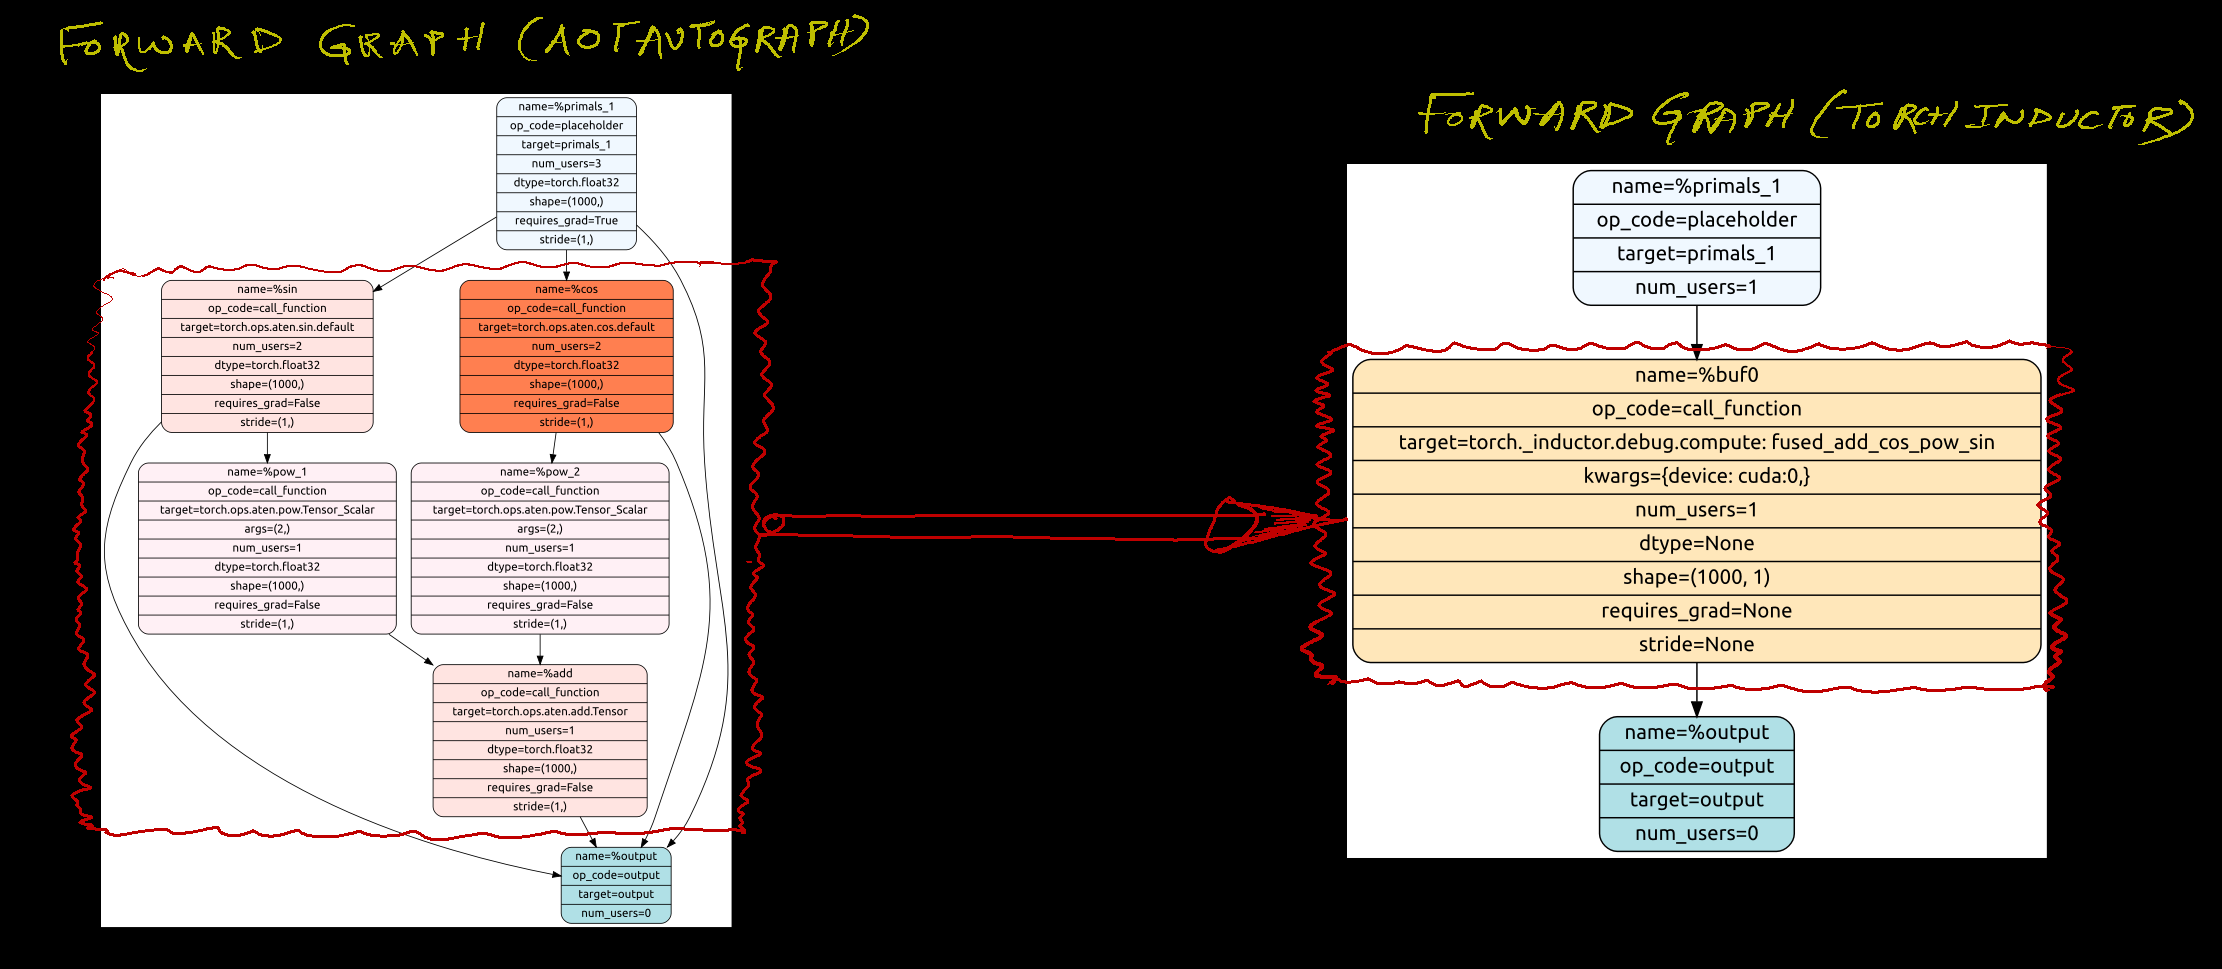

### Define-By-Run Loop Level IR (TorchInductor IR)

In the above debug logs we some code as follows for the foward graph:
```py
 scheduling ComputedBuffer(name='buf0', layout=FixedLayout('cuda', torch.float32, size=[1000], stride=[1]), data=Pointwise(
   'cuda',
   torch.float32,
   def inner_fn(index):
       i0 = index
       tmp0 = ops.load(primals_1, i0)
       tmp1 = ops.sin(tmp0)
       tmp2 = tmp1 * tmp1
       tmp3 = ops.load(primals_1, i0)
       tmp4 = ops.cos(tmp3)
       tmp5 = tmp4 * tmp4
       tmp6 = tmp2 + tmp5
       return tmp6
   ,
   ranges=[1000],
   origin_node=add,
   origins={pow_1, sin, cos, add, pow_2}
 ))
```

The Aten IR which TorchInductor gets as input is used to generate this above define-by-run loop level run. The operations mentioned in the ATen IR are lowered to the torch inductor "ops.*".

The function definition `inner_fn` shown above is used to populate each elment of the output buffer, using a loop.

The `range` above having a value `1000` shows that this function shall be used interally 1000 times in a loop to generate each of the 1000 elements.

Certain layout decisions are also made in a approach called `scheduling`.

The above TorchInductor IR is called "Define-By-Run" because the "ops" are overloaded in different passes to perform different operations. For example "ops" may be overloaded to a some kind which is useful for doing operator fusion. While, again, the "ops" can be overloaded to something like "codegen" to do the codegen.

A comparison of the output triton forward graph codegen with the DBR-IR:
```py
triton_poi_fused_add_cos_pow_sin_0 = async_compile.triton('triton_', '''
import triton
import triton.language as tl
from triton.compiler.compiler import AttrsDescriptor

from torch._inductor.runtime import triton_helpers, triton_heuristics
from torch._inductor.runtime.triton_helpers import libdevice, math as tl_math
from torch._inductor.runtime.hints import AutotuneHint, ReductionHint, TileHint, instance_descriptor, DeviceProperties

@triton_heuristics.pointwise(
    size_hints=[1024], 
    filename=__file__,
    triton_meta={'signature': {0: '*fp32', 1: '*fp32', 2: 'i32'}, 'device': DeviceProperties(type='cuda', index=0, cc=75, major=7, regs_per_multiprocessor=65536, max_threads_per_multi_processor=1024, multi_processor_count=46), 'constants': {}, 'configs': [AttrsDescriptor(divisible_by_16=(0, 1), equal_to_1=())]},
    inductor_meta={'autotune_hints': set(), 'kernel_name': 'triton_poi_fused_add_cos_pow_sin_0', 'mutated_arg_names': [], 'no_x_dim': False, 'num_load': 1, 'num_reduction': 0, 'backend_hash': '6e95335dfe32e7159670fdd0127b9a4b9aafe61a035a1d09d747878c52d0b360', 'are_deterministic_algorithms_enabled': False, 'assert_indirect_indexing': True, 'autotune_local_cache': True, 'autotune_pointwise': True, 'autotune_remote_cache': False, 'force_disable_caches': False, 'dynamic_scale_rblock': True, 'max_autotune': False, 'max_autotune_pointwise': False, 'min_split_scan_rblock': 256, 'spill_threshold': 16, 'store_cubin': False},
    min_elem_per_thread=0
)
@triton.jit
def triton_(in_ptr0, out_ptr0, xnumel, XBLOCK : tl.constexpr):
    xnumel = 1000
    xoffset = tl.program_id(0) * XBLOCK
    xindex = xoffset + tl.arange(0, XBLOCK)[:]
    xmask = xindex < xnumel
    x0 = xindex
    tmp0 = tl.load(in_ptr0 + (x0), xmask)
    tmp1 = tl_math.sin(tmp0)
    tmp2 = tmp1 * tmp1
    tmp3 = tl_math.cos(tmp0)
    tmp4 = tmp3 * tmp3
    tmp5 = tmp2 + tmp4
    tl.store(out_ptr0 + (x0), tmp5, xmask)
''', device_str='cuda')
```

Comparision of the Inductor IR code with Output Triton Codegen

